# Exploring Euro Data Cube

The following command is necessary if a python library is not yet installed in the Euro Data Cube environment.

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} rasterstats

In [198]:
# xcube_geodb imports
from xcube_geodb.core.geodb import GeoDBClient

# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
from datetime import date, timedelta
import xarray as xr
import shapely.geometry
from shapely.ops import unary_union
import IPython.display
from IPython.display import display
import zarr
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray as rx
from scipy import interpolate

# Sentinel Hub
from sentinelhub import BBox, SentinelHubRequest, bbox_to_dimensions, DataCollection, MimeType, SHConfig, geometry, geo_utils

## Define an AOI

We will define our area of interest using a bounding box. This must be provided in WGS84 coordinates to build the cube.

To find the coordinates of a bounding box, check: http://bboxfinder.com/ 

To transform between coordinate systems, go to; https://epsg.io/transform 

In [12]:
# EPSG : 3794
# -----------

# ulx = 455273
# uly = 97061
# lrx = 470494
# lry = 106169

# bbox_coords_3794 = (ulx, uly, lrx, lry)

# EPSG : 4326
# -----------

ulx = 4.475555
uly = 50.585852
lrx = 4.700775
lry = 50.712982

bbox_coords_4326 = ulx, uly, lrx, lry

bbox_coords_4326_1 = lrx, lry, ulx, uly

In [13]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(bbox_coords_4326,crs=4326).get_geojson())

<IPython.display.GeoJSON object>

## In Situ data
### Connecting to the GeoDB

In [6]:
# Fetch the GeoDB client
geodb = GeoDBClient()

# If you are logged in, this will tell you what account the system currently uses
geodb.whoami

'geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6'

### List all collections

In [7]:
all_collections = geodb.get_my_collections()
#all_collections = my_collection.loc[my_collection['owner'] == geodb.whoami]

all_collections

owner  \
0    geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c   
1    geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c   
2    geodb_0d6df427-8c09-41b9-abc9-64ce13a68125   
3    geodb_0d6df427-8c09-41b9-abc9-64ce13a68125   
4    geodb_0e5d743f-2134-4561-8946-a073b039176f   
..                                          ...   
878                              geodb_geodb_ci   
879                       geodb_lpis_iacs_admin   
880                       geodb_lpis_iacs_admin   
881                       geodb_lpis_iacs_admin   
882                       geodb_lpis_iacs_admin   

                                       database            collection  \
0    geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c  delineated_parcels_s   
1    geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c            test_batic   
2    geodb_0d6df427-8c09-41b9-abc9-64ce13a68125              land_use   
3    geodb_0d6df427-8c09-41b9-abc9-64ce13a68125              lpis_aut   
4    geodb_0e5d743f-2134-4561-8946-a073b039176f          ai4eo_bboxes   
..                                          ...                   ...   
878                              geodb_geodb_ci              land_use   
879                                   lpis_iacs          land_use_slo   
880                                   lpis_iacs              lpis_aut   
881                                   lpis_iacs              lpis_slo   
882                                   lpis_iacs              metadata   

               table_name  
0    delineated_parcels_s  
1              test_batic  
2                land_use  
3                lpis_aut  
4            ai4eo_bboxes  
..                    ...  
878              land_use  
879          land_use_slo  
880              lpis_aut  
881              lpis_slo  
882              metadata  

[883 rows x 4 columns]

### List the collections made accessible for AVL project

In [8]:
avl_collection = geodb.get_my_collections(database="avl")

avl_collection

owner database     collection  \
0  geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6      avl   lpis_belgium   
1  geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6      avl    lpis_france   
2  geodb_17c146f6-e133-4ab9-8c9b-6eef968876d6      avl  lpis_wallonia   

      table_name  
0   lpis_belgium  
1    lpis_france  
2  lpis_wallonia

For this example, we will access a dataset called `lpis_belgium` in the `avl` database. This dataset represents Land Cover for Belgium in 2019. Since it is a large collection, we will limit the request to the first 10 entries.

In [10]:
gdf_head = geodb.get_collection_pg(collection='lpis_belgium',
                                   database='avl',
                                   limit=10)

# To get only the 10 first entries, we can use "head_collection"

#gdf_head = geodb.head_collection(collection='lpis_belgium',
#                                 database='avl') 

gdf_head

id                        created_at modified_at  \
0   1  2021-08-17T11:41:46.646124+00:00        None   
1   2  2021-08-17T11:41:46.646124+00:00        None   
2   3  2021-08-17T11:41:46.646124+00:00        None   
3   4  2021-08-17T11:41:46.646124+00:00        None   
4   5  2021-08-17T11:41:46.646124+00:00        None   
5   6  2021-08-17T11:41:46.646124+00:00        None   
6   7  2021-08-17T11:41:46.646124+00:00        None   
7   8  2021-08-17T11:41:46.646124+00:00        None   
8   9  2021-08-17T11:41:46.646124+00:00        None   
9  10  2021-08-17T11:41:46.646124+00:00        None   

                                            geometry  ori_crop  cropnum  \
0  MULTIPOLYGON (((201416.633 187986.448, 201459....      1053     1053   
1  MULTIPOLYGON (((163321.100 122418.700, 163329....      1051     1051   
2  MULTIPOLYGON (((197997.700 131339.351, 198127....      1051     1051   
3  MULTIPOLYGON (((167722.406 194510.682, 167749....      1028     1028   
4  MULTIPOLYGON (((177113.807 208653.956, 177145....      1051     1051   
5  MULTIPOLYGON (((221544.000 78617.750, 221540.2...      1051     1051   
6  MULTIPOLYGON (((246159.750 69505.250, 246176.5...      1051     1051   
7  MULTIPOLYGON (((180277.529 120185.519, 180290....      8515     8515   
8  MULTIPOLYGON (((207316.833 63843.333, 207367.6...      1051     1051   
9  MULTIPOLYGON (((186180.896 162265.483, 186197....      1051     1051   

       cropname  unique_id  holding_id  ori_id  ... ctnuml4a         ctl4a  \
0        Fallow    94904.0         1.0   94904  ...     1053        Fallow   
1     Grassland   220622.0         1.0  220622  ...     1051     Grassland   
2     Grassland   236306.0         1.0  236306  ...     1051     Grassland   
3         Maize   117640.0         1.0  117640  ...     1028         Maize   
4     Grassland   122892.0         1.0  122892  ...     1051     Grassland   
5     Grassland   204132.0         1.0  204132  ...     1051     Grassland   
6     Grassland   248200.0         1.0  248200  ...     1051     Grassland   
7  Strawberries   279534.0         1.0  279534  ...     8515  Strawberries   
8     Grassland   211971.0         1.0  211971  ...     1051     Grassland   
9     Grassland    23460.0         1.0   23460  ...     1051     Grassland   

   ctnumdiv                  ctdiv  eaa  al  pgrass  tgrass  fallow  cwater  
0     10053                 Fallow    0   0       0       0       0       0  
1     10051              Grassland    1   1       0       1       0       0  
2     10051              Grassland    1   1       0       1       0       0  
3     10028                  Maize    1   1       0       0       0       0  
4     10051              Grassland    1   1       0       1       0       0  
5     10051              Grassland    1   1       0       1       0       0  
6     10051              Grassland    1   1       0       1       0       0  
7      9516  Strawberries (yearly)    1   1       0       0       0       0  
8     10051              Grassland    1   1       0       1       0       0  
9     10051              Grassland    1   1       0       1       0       0  

[10 rows x 37 columns]

Fetch all polygons inside the given bounding box

In [29]:
gdf_lln = geodb.get_collection_by_bbox(collection='lpis_belgium',
                                       database='avl',
                                       bbox = bbox_coords_4326,
                                       comparison_mode="contains",
                                       bbox_crs=4326)

Plot all polygons inside the given bounding box 

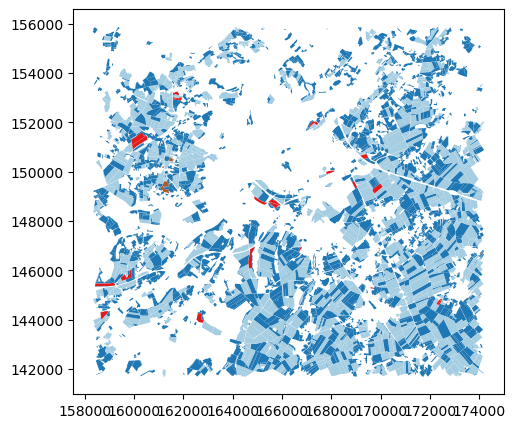

In [27]:
gdf_lln.plot(column="cropnum",
             figsize=(8,5),
             cmap = 'Paired')
plt.show()

In [30]:
# Convert the coordinate system to EPSG : 4326 coordinates
print(f"Original CRS :{gdf_lln.crs}")

gdf_lln = gdf_lln.to_crs(epsg=4326)

print(f"New CRS      :{gdf_lln.crs}")

Original CRS EPSG:31300
New CRS epsg:4326


In [31]:
gdf_lln.head()

id                        created_at modified_at  \
0  243  2021-08-17T11:41:46.646124+00:00        None   
1  402  2021-08-17T11:41:46.646124+00:00        None   
2  520  2021-08-17T11:41:46.646124+00:00        None   
3  524  2021-08-17T11:41:46.646124+00:00        None   
4  581  2021-08-17T11:41:46.646124+00:00        None   

                                            geometry  ori_crop  cropnum  \
0  MULTIPOLYGON (((4.55826 50.58735, 4.55814 50.5...        36       36   
1  MULTIPOLYGON (((4.65102 50.65928, 4.65065 50.6...      1053     1053   
2  MULTIPOLYGON (((4.69421 50.62635, 4.69602 50.6...      1051     1051   
3  MULTIPOLYGON (((4.51859 50.66201, 4.51874 50.6...      1051     1051   
4  MULTIPOLYGON (((4.61318 50.61343, 4.61803 50.6...       901      901   

             cropname  unique_id  holding_id  ori_id  ... ctnuml4a  \
0               Spelt   367794.0         1.0  367794  ...       36   
1              Fallow   342352.0         1.0  342352  ...     1053   
2           Grassland   345626.0         1.0  345626  ...     1051   
3           Grassland   366161.0         1.0  366161  ...     1051   
4  Potato (non-early)   328679.0         1.0  328679  ...      901   

                ctl4a  ctnumdiv               ctdiv  eaa  al  pgrass  tgrass  \
0               Spelt        36               Spelt    1   1       0       0   
1              Fallow     10053              Fallow    0   0       0       0   
2           Grassland     10051           Grassland    1   1       0       1   
3           Grassland     10051           Grassland    1   1       0       1   
4  Potato (non-early)       901  Potato (non-early)    1   1       0       0   

   fallow  cwater  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  

[5 rows x 37 columns]

Make a subset of the polygons that are not 
- grassland (~ cropnum:id=1051)
- building (~ cropnum:id=1)
- Other vegetables (~ cropnum:id=1035)
- Hedge of trees (between crops) (~ cropnum:id=4)
- Fallow (~ cropnum:id=1053)
- Unspecified crop - small farmer (~ cropnum:id=999)
- Other herbs plants (~ cropnum:id=1034)
- Other stables and buildings (~ cropnum:id=2)
- Managed strip (~ cropnum:id=754)
- Other vegetables (greenhouse) (~ cropnum:id=9521)
- Greenhouse crops (market garden) (~ cropnum:id=952)
- Other cover (sowing) (~ cropnum:id=85)
- Heath in nature management (~ cropnum:id=9825)
- Ponds < = 0.1 ha (~ cropnum:id=3)
- Other afforestation (~ cropnum:id=894)
- Park (~ cropnum:id=8)
- Mixture of grass and legumes (other than grass clover) (~ cropnum:id=745)
- Buffer strip (along watercourse) (~ cropnum:id=752)
- Other ornamental plants (greenhouse) (~ cropnum:id=958)
- Pasture (area ? 50 %) (~ cropnum:id=1059)
- Permanent greenhouse crops (~ cropnum:id=885)
- Seeds multiplication for organic crops (~ cropnum:id=821)
- Unsealed runway or safety zones at airports (~ cropnum:id=9)


In [38]:
list_cropnum_to_remove = [1051, 1, 1035, 4, 1053, 999, 1034, 2, 754, 9521, 952, 85, 9825, 3, 894, 8, 745, 752, 958, 1059, 885, 821, 9]

gdf_lln_sub = gdf_lln[~gdf_lln.cropnum.isin(list_cropnum_to_remove)]


#gdf_lln_sub = gdf_lln.loc[(gdf_lln['cropnum'] != 1051) & (gdf_lln['cropnum'] != 1) & (gdf_lln['cropnum'] != 1035) & (gdf_lln['cropnum'] != 4) & (gdf_lln['cropnum'] != 1053) & (gdf_lln['cropnum'] != 999) &
#                        (gdf_lln['cropnum'] != 1034) & (gdf_lln['cropnum'] != 2) & (gdf_lln['cropnum'] != 754) & (gdf_lln['cropnum'] != 9521) & (gdf_lln['cropnum'] != 952) & (gdf_lln['cropnum'] != 85) & 
#                        (gdf_lln['cropnum'] != 9825) & (gdf_lln['cropnum'] != 3) & (gdf_lln['cropnum'] != 894) & (gdf_lln['cropnum'] != 8) & (gdf_lln['cropnum'] != 745) & (gdf_lln['cropnum'] != 752) &
#                        (gdf_lln['cropnum'] != 958) & (gdf_lln['cropnum'] != 1059) & (gdf_lln['cropnum'] != 885) & (gdf_lln['cropnum'] != 821) & (gdf_lln['cropnum'] != 9)]


print(len(gdf_lln))
print(len(gdf_lln_sub))
# display(gdf_lln_subset)

3655
2272


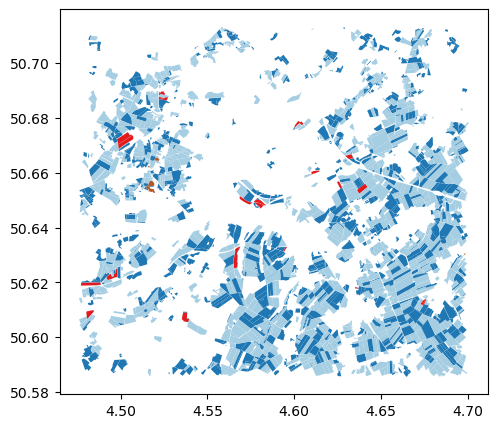

In [43]:
gdf_lln_sub.plot(column="cropnum",
                 figsize=(8,5),
                 cmap = 'Paired')
plt.show()

In [ ]:
gdf_lln_sub.to_file(in_situ_file)

 ## EO data
 ### Configuring the data content of the cube

Now we specify the properties of our cube. 
First, the satellite and processing level of data to be integrated is specified. In this case, the Sentinel-2 Level 2A data will be used.

In the second row, the spectral bands are selected, which should be integrated. As we need to calculate NDVI index, we will need red and NIR bands (B04 and B08 of Sentinel-2).

Also, the time range and time period of the cube is specified in this step. In this case, we will be interested in data acquired between 14 May and 31 July 2018. A custom days time period will be used.

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S2L2A` for Sentinel-2 L2A. All available datasets can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call the B04, B08, B11, SCL, CLD (Red, NIR, SWIR, scene classification layer, Raster mask values range from 0 for high confidence clear sky to 100 for high confidence cloudy) bands.

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 10 meters, we set the resolution to 0.000089 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-2 L2A data is available from October 2016 onwards. In this example, we will fetch data for 28 August 2019 and 100 days before.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30M` corresponds to 30 minutes, thus avoiding duplicate datasets.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [48]:
dataset_name = 'S2L2A'
band_names = ['B04', 'B08', 'B11', 'SCL', 'CLD']
tile_size = [512, 512]
spatial_res = 0.000089   # = 10.038 meters in degree

# Time range and time period of the cube

#days = 100
#end_date = date(2019, 8, 28)
#time_range = [(end_date - timedelta(days=days)).strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")]

start_date = '2018-05-14'
end_date   = '2018-07-31'

time_range = [start_date, end_date]
time_period = '5D'
time_tolerance = '30M'

#### Setting cube configurations

In [47]:
cube_config = CubeConfig(dataset_name = dataset_name,
                         band_names = band_names,
                         tile_size = tile_size,
                         bbox = bbox_coords_4326,
                         spatial_res = spatial_res,
                         time_range = time_range,
                         time_period = time_period,
                         time_tolerance = time_tolerance)

#### Defining a "request collector"
We define a `request_collector` as an observer for SentinelHub (SH) requests made, so we can show SH usage statistics. 

In [49]:
request_collector = Observers.request_collector()

#### Loading data into the cube + Verifying the content of the cube

Now, when the cube is correctly specified, we can open it. A lazy loading technique is used - it means that the data is loaded to the cube only when we actually use it (for some calcualtion, vizualization etc.). 

Once the cube is opened, we can check whether it has been created in accordance with our expectations. 

The Cube Dataset information can be displayed, enabling to verify that the cube is specified correctly.

In [50]:
# Open cube (on the fly)
cube = open_cube(cube_config, observer=request_collector)

cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 1536, lon: 2560, time: 16)
Coordinates:
  * lat        (lat) float64 50.72 50.72 50.72 50.72 ... 50.59 50.59 50.59 50.59
  * lon        (lon) float64 4.476 4.476 4.476 4.476 ... 4.703 4.703 4.703 4.703
  * time       (time) datetime64[ns] 2018-05-16T12:00:00 ... 2018-07-30T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(16, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-09-22T14:02:53.222059
    time_coverage_start:       2018-05-14T00:00:00+00:00
    time_coverage_end:         2018-08-02T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    geospatial_lon_min:        4.475555
    geospatial_lat_min:        50.585852
    geospatial_lon_max:        4.7033949999999995
    geospatial_lat_max:        50.722556000000004
    processing_level:          L2A

#### Displaying information on specific band in the cube
It is possible to check each band loaded into the cube separately. In this case, we will check the band 04 (RED) and then band 08 (NIR)

In [51]:
cube.B04

<xarray.DataArray 'B04' (time: 16, lat: 1536, lon: 2560)>
dask.array<open_dataset-579449aa78f248828b876c37d1dc96a8B04, shape=(16, 1536, 2560), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 50.72 50.72 50.72 50.72 ... 50.59 50.59 50.59 50.59
  * lon      (lon) float64 4.476 4.476 4.476 4.476 ... 4.703 4.703 4.703 4.703
  * time     (time) datetime64[ns] 2018-05-16T12:00:00 ... 2018-07-30T12:00:00
Attributes:
    sample_type:   FLOAT32
    units:         reflectance
    wavelength:    664.75
    wavelength_a:  664.6
    wavelength_b:  664.9
    bandwidth:     31.0
    bandwidth_a:   31
    bandwidth_b:   31
    resolution:    10

#### Displaying cube data for selected band and time step as imageries

We can also display the data for any combination of selected spectral band and time step of the times serie contained in the cube as an imagery. We may need this to check the data visually, over entire area of interest (geographical extent of the cube).
For example we'll select the time step 2018-06-20 and display the data as image for both spectral bands contianed in the cube (B04 RED and B08 NIR).

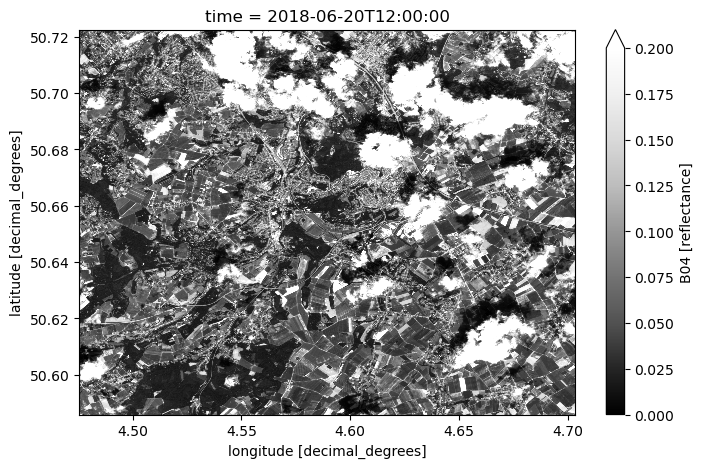

In [63]:
cube.B04.sel(time='2018-06-20 12:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(8, 5))
plt.show()

# Masking out water and clouds

In [64]:
# Create mask based on Scene Classification Layer
mask = MaskSet(cube.SCL)
mask

Make a datacube with all clouds masked out:

In [53]:
cube_wo_clouds = cube.where(xr.ufuncs.logical_not(mask.saturated_or_defective |
                                                  mask.dark_area_pixels |
                                                  mask.cloud_shadows |
                                                  mask.water |
                                                  mask.clouds_low_probability_or_unclassified |
                                                  mask.clouds_medium_probability |
                                                  mask.clouds_high_probability |
                                                  mask.cirrus |
                                                  mask.snow_or_ice))

Take a look at a time stamp without any masking:

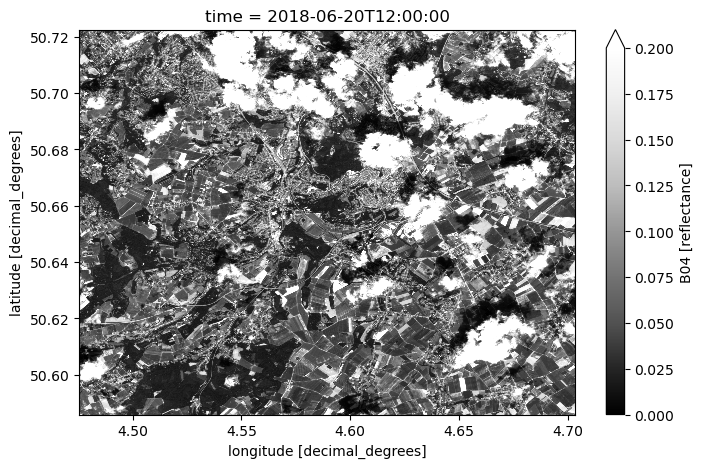

In [57]:
cube.B04.sel(time='2018-06-20 12:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(8, 5))
plt.show()

Now let's take a look at the same time stamp with masking:

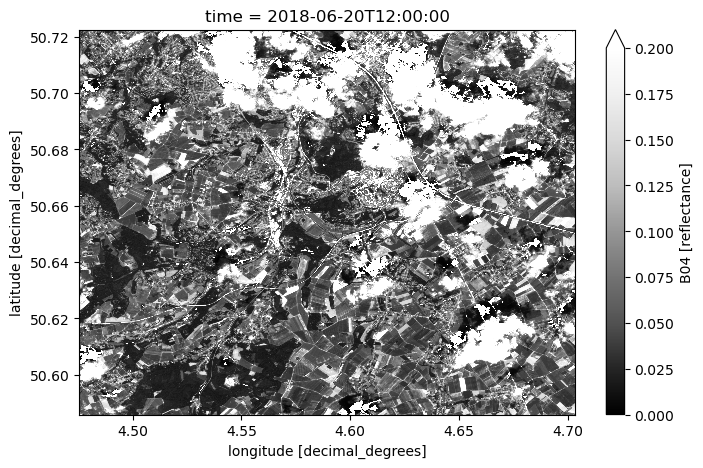

In [58]:
cube_wo_clouds.B04.sel(time='2018-06-20 12:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(8, 5))
plt.show()

#### Displaying values for each time step in the time serie (red band = band 04)
Once the cube is built and time serie generated, we can display the spectral values for each time step of the serie. 

For this example we'll select a point at latitude=50.594946, longitude=4.680916 inside our area of interest (or geographical extent of the cube).

In this case, the nearest-neighbor interpolation methods is used by xcube. Nearest neighbour interpolation is the simplest approach to interpolation. This method simply determines the “nearest” neighbouring pixel, and assumes the intensity value of it.

In [60]:
x = 50.594946
y = 4.680916

timeseriesB04 = cube_wo_clouds.B04.sel(lat=x, lon=y, method='nearest').to_series()
#timeseriesB04

time
2018-05-16 12:00:00    0.0485
2018-05-21 12:00:00       NaN
2018-05-26 12:00:00    0.0563
2018-05-31 12:00:00       NaN
2018-06-05 12:00:00       NaN
2018-06-10 12:00:00       NaN
2018-06-15 12:00:00       NaN
2018-06-20 12:00:00    0.0508
2018-06-25 12:00:00    0.0546
2018-06-30 12:00:00    0.0709
2018-07-05 12:00:00    0.1275
2018-07-10 12:00:00    0.1022
2018-07-15 12:00:00    0.1271
2018-07-20 12:00:00    0.1737
2018-07-25 12:00:00    0.1186
2018-07-30 12:00:00    0.1884
Name: B04, dtype: float32

#### Displaying values for each time step in the time serie in a linear plot (band 04)
Once the maplot library is imported, the same spectral values for each step of the time serie can be displayed also in a linear chart. 

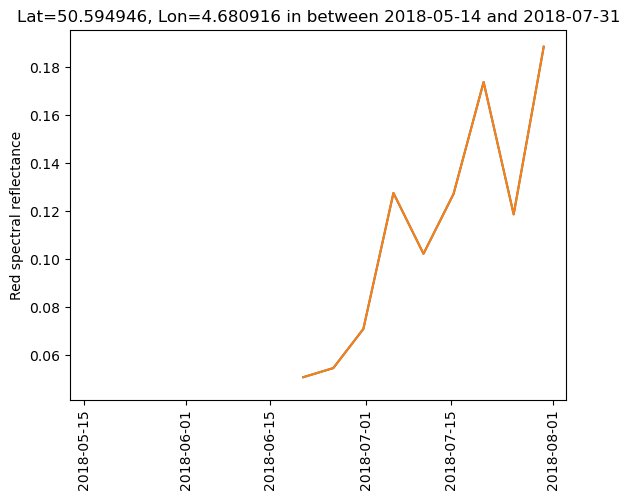

In [62]:
plt.plot(timeseriesB04)
plt.xticks(rotation='vertical')
plt.figsize=(15, 6)
plt.ylabel('Red spectral reflectance')
plt.title(f'Lat={x}, Lon={y} in between {start_date} and {end_date}')
plt.show()

#### Create a mask based on the agricultural land geometries


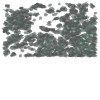

In [82]:
#poly = gpd.GeoDataFrame(gdf_lln_sub.geometry, crs="EPSG:4326")

gdf_lln_sub = gdf_lln_sub.to_crs(epsg=4326)  # To be sure that all polygons are in WGS84

# Assemble all selected polygons in a single polygon
single_poly = gdf_lln_sub.geometry.unary_union
single_poly

In [90]:
cube_masked = mask_dataset_by_geometry(cube_wo_clouds, geometry=single_poly)
cube_masked

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 1433, lon: 2522, time: 16)
Coordinates:
  * lat        (lat) float64 50.71 50.71 50.71 50.71 ... 50.59 50.59 50.59 50.59
  * lon        (lon) float64 4.476 4.476 4.476 4.476 4.476 ... 4.7 4.7 4.7 4.701
  * time       (time) datetime64[ns] 2018-05-16T12:00:00 ... 2018-07-30T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(16, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 410, 506), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 410, 506), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 410, 506), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 410, 506), meta=np.ndarray>
Attributes: (12/18)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2021-09-22T14:02:53.222059
    time_coverage_start:        2018-05-14T00:00:00+00:00
    time_coverage_end:          2018-08-02T00:00:00+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  8.90000000000001e-05
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  8.899999999999582e-05
    date_modified:              2021-09-22T14:35:18.291765

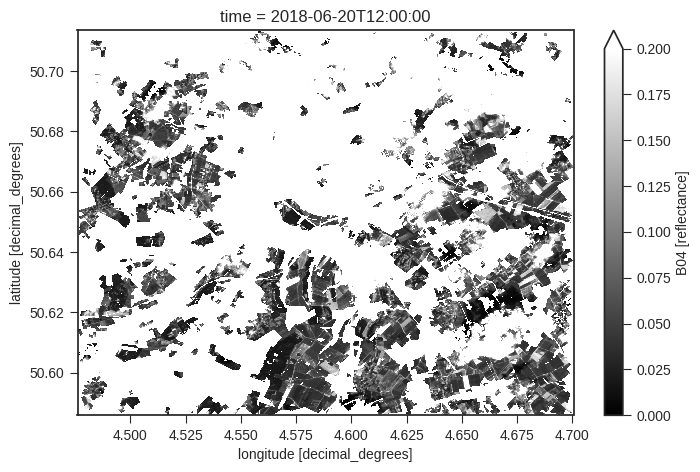

In [91]:
cube_masked.B04.sel(time='2018-06-20 10:00:00', method='nearest').plot.imshow(vmin=0.0,
                                                                              vmax=0.2,
                                                                              cmap='gray',
                                                                              figsize=(8, 5))
plt.show()

### Preparing values for NDVI - Normalized Difference Vegetation Index
Now we will prepare values for the new NDVI layer, based on combination of the bands already contained in our cube.

We are going to compute NDVI indexes from bands B04 and B08 of Sentinel-2 (S2L2A), using following well-know prescription:

$$ NDVI = \frac{NIR - RED}{NIR + RED} = \frac{B08 - B04}{B08 + B04}$$

In [92]:
ndvi = (cube_masked.B08-cube_masked.B04)/(cube_masked.B04+cube_masked.B08)

#### Specifying properties of new NDVI layer
We can also specify some properties of the new NDVI layer, which should be added into our cube - in this case, we set the "long name" and units of the layer.

In [93]:
ndvi.attrs['long_name']='NDVI'
ndvi.attrs['units']='unitless'

#### Adding a new NDVI layer to cube
Now the values are calculated and the properties specified, we can easilly add the new NDVI layer into our cube.

In [94]:
cube_masked['NDVI']=ndvi

#### Displaying information for NDVI layer
Again, as in case of original bands B04 and B08, we can ceck the properties of the NDVI layer.

In [95]:
cube_masked.NDVI

<xarray.DataArray 'NDVI' (time: 16, lat: 1433, lon: 2522)>
dask.array<truediv, shape=(16, 1433, 2522), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 50.71 50.71 50.71 50.71 ... 50.59 50.59 50.59 50.59
  * lon      (lon) float64 4.476 4.476 4.476 4.476 4.476 ... 4.7 4.7 4.7 4.701
  * time     (time) datetime64[ns] 2018-05-16T12:00:00 ... 2018-07-30T12:00:00
Attributes:
    long_name:  NDVI
    units:      unitless

#### Displaying time serie of NDVI
Also, we can display time serie of values of NDVI band at selected location for all time steps.

For example we'll select the point at latitude= 50.594946, longitude= 4.680916
Nearest-neighbor interpolation is used by xcube to find closest satellite pixel at each time step.

In [74]:
x = 50.594946
y = 4.680916

timeseriesNDVI = cube_masked.NDVI.sel(lat=x, lon=y, method='nearest').to_series()
#timeseriesNDVI

#### Displaying time serie of NDVI in linear plot
Now, when we computed the NDVI values for each step in the time serie, we can easily display them in linear plot, as in case of original Sentinel-2 bands.

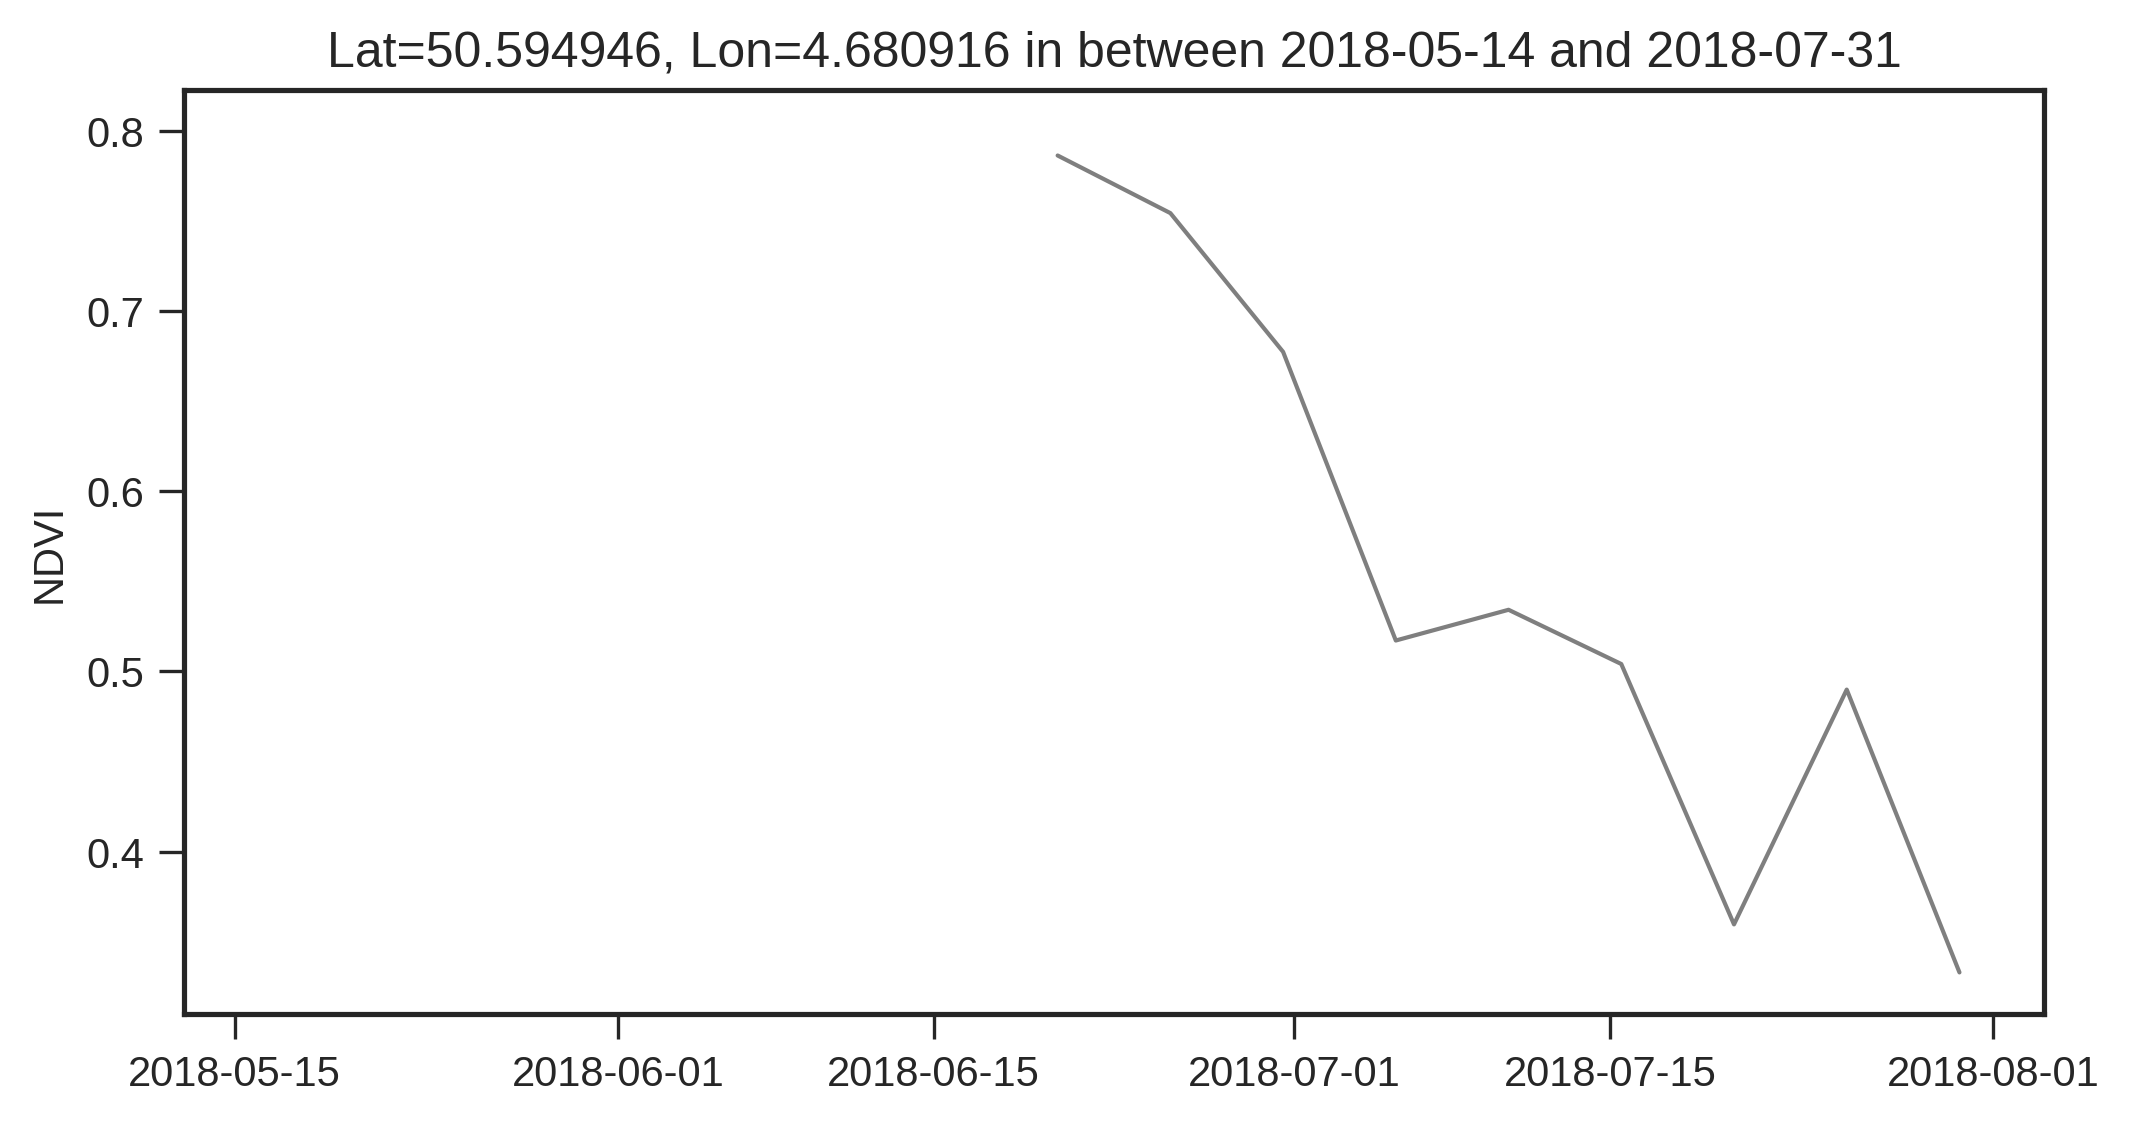

In [77]:
plt.style.use('seaborn-ticks')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
plt.ylabel('NDVI')
plt.title(f'Lat={x}, Lon={y} in between {start_date} and {end_date}')
plt.plot(timeseriesNDVI, c='black',linewidth = 1,alpha=0.5,zorder=1)

plt.show()

Plotting time-series NDVI data produces a temporal curve that summarizes the various stages that green vegetation undergoes during a complete growing season. 
Such curves can be analyzed to extract key phenological variables, or metrics, about a particular season, such as the start, peak and end of the growing season. These characteristics may correspond directly to conventional, ground-based phenological events like growing (the NDVI values grows), mowing, harvesting or ploughing (NDVI values drops rapidly) and provide indications of ecosystem dynamics.

### Plot NDVI image for specific date

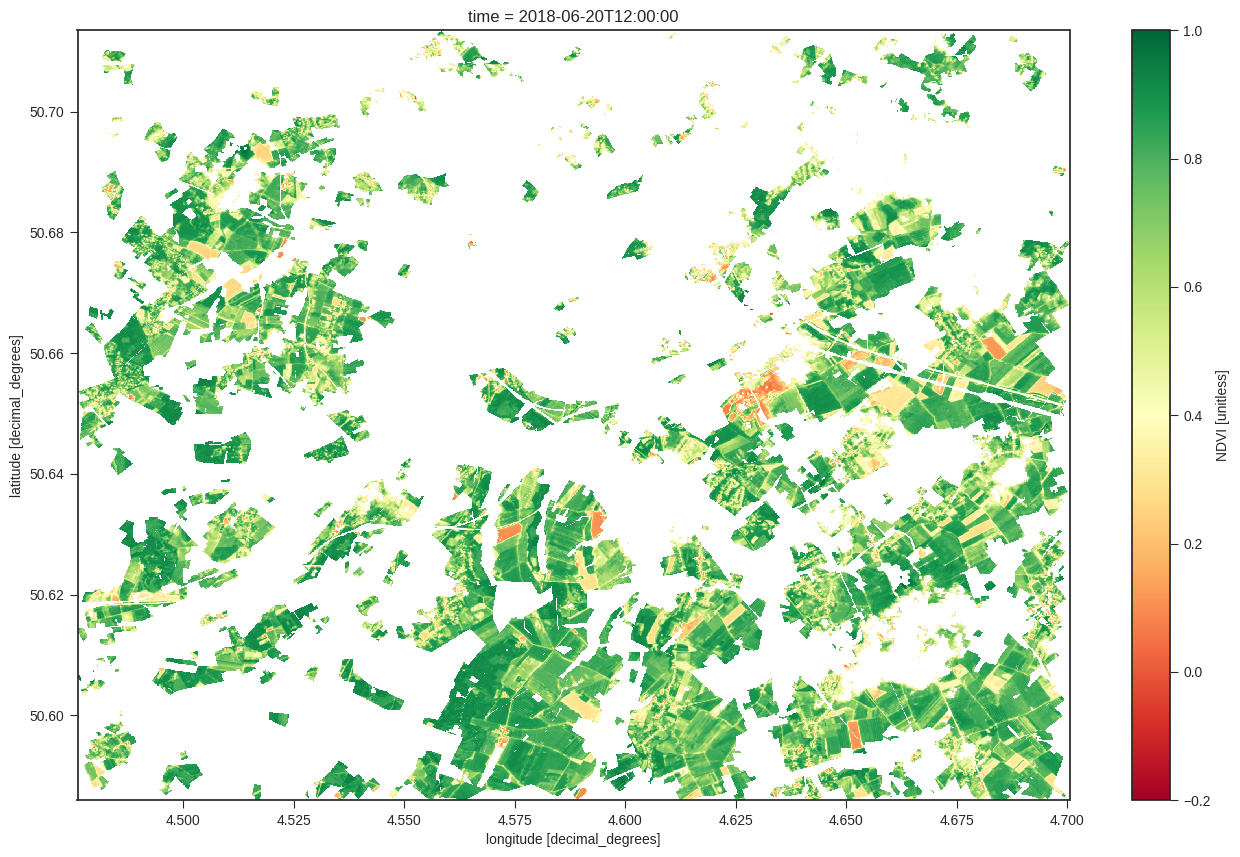

In [78]:
cube_masked.NDVI.sel(time='2018-06-20 12:00:00', method='nearest').plot.imshow(vmin=-0.2,
                                                                               vmax=1,
                                                                               cmap='RdYlGn',
                                                                               figsize=(16, 10))
plt.show()

### Compute NDVI mean for each polygon

In [194]:
gdf_lln_poly = gdf_lln_sub.iloc[10]['geometry']

cube_masked_by_polygon = mask_dataset_by_geometry(cube_masked, geometry=gdf_lln_poly)

ndvi_single_date = cube_masked_by_polygon.NDVI.sel(time='2018-05-20 12:00:00', method='nearest')
print(ndvi_single_date.shape)

ndvi_single_date_mean = np.nanmean(ndvi_single_date)
print(ndvi_single_date_mean)


print("-------------------")

ndvi_all_dates = cube_masked_by_polygon.NDVI
print(ndvi_all_dates.shape)

ndvi_all_dates_mean = np.nanmean(ndvi_all_dates, axis=(2,1))
print(ndvi_all_dates_mean)

(10, 18)
nan
-------------------
(16, 10, 18)


<ipython-input-194-58c617dddf81>:8: RuntimeWarning: Mean of empty slice
  ndvi_single_date_mean = np.nanmean(ndvi_single_date)


[0.1098836         nan 0.2377689         nan        nan        nan
        nan 0.83183795 0.8330115  0.82994765 0.7378059  0.45106548
 0.70126706 0.7669554  0.6183999  0.6082086 ]


<ipython-input-194-58c617dddf81>:17: RuntimeWarning: Mean of empty slice
  ndvi_all_dates_mean = np.nanmean(ndvi_all_dates, axis=(2,1))


In [205]:
print(ndvi_all_dates_mean)

a = pd.Series(ndvi_all_dates_mean)

test = a.interpolate()
print(test)

[0.1098836         nan 0.2377689         nan        nan        nan
        nan 0.83183795 0.8330115  0.82994765 0.7378059  0.45106548
 0.70126706 0.7669554  0.6183999  0.6082086 ]
0     0.109884
1     0.173826
2     0.237769
3     0.356583
4     0.475397
5     0.594210
6     0.713024
7     0.831838
8     0.833012
9     0.829948
10    0.737806
11    0.451065
12    0.701267
13    0.766955
14    0.618400
15    0.608209
dtype: float32


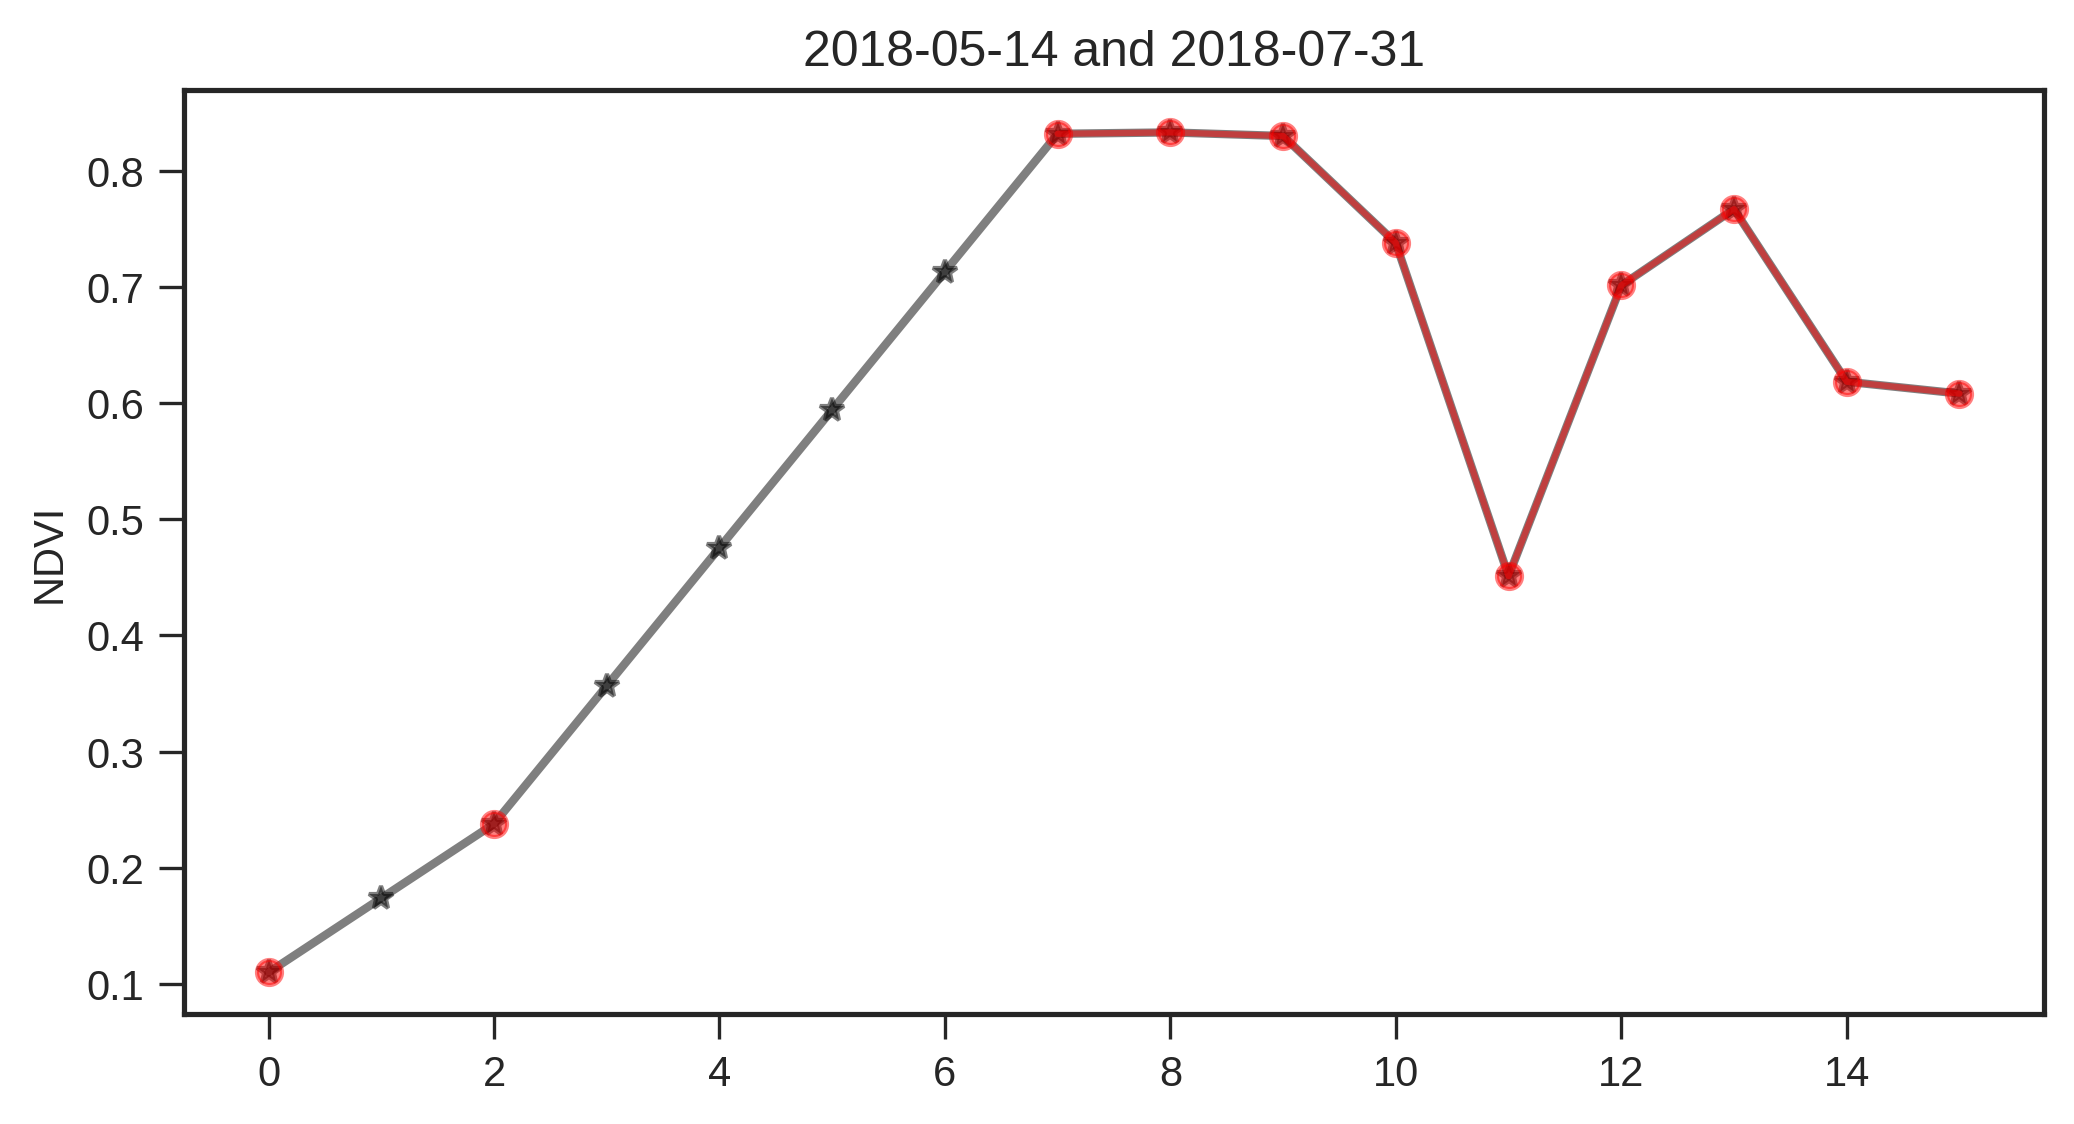

In [215]:
fig, ax = plt.subplots(figsize=(8,4), dpi=300)
plt.ylabel('NDVI')
plt.title(f'{start_date} and {end_date}')
plt.plot(test, '-*', c='black',linewidth = 2,alpha=0.5,zorder=1)
plt.plot(ndvi_all_dates_mean, c='red', marker='o',alpha=0.5,zorder=2)

plt.show()

In [ ]:
cube_masked_by_polygon.NDVI.sel(time='2018-05-20 12:00:00', method='nearest').plot.imshow(vmin=-0.2,
                                                                               vmax=1,
                                                                               cmap='RdYlGn',
                                                                               figsize=(16, 10))
plt.show()

#### Calculations on NDVI

Since we have all the required NDVI data now in our python runtime, we can easily calculate some metrics:


In [34]:
# for ndvi_date in ndvi:
#     print(
#         {
#             "date": str(ndvi_date.time.values),
#             "max": np.nanmax(ndvi_date.values),
#             "mean": np.nanmean(ndvi_date.values),
#             "min": np.nanmin(ndvi_date.values),
#             "stDev": np.nanstd(ndvi_date.values),
#         }
#     )


By iterating over NDVI, we obtain the values for every point in time. The accessor value returns the numpy.ndarray which holds the actually data. We can use it for doing our actual calculations.

#### Displaying NDVI for all time steps in the serie as image

To check the NDVI values over whole area of interest for all time step in the time serie, 
we can display the NDVI values for all selected time steps of the serie as image in the same color scale beside each other. 
This allows us to visually compare the development of NDVI values over whole time serie and to compare various time steps with each other.

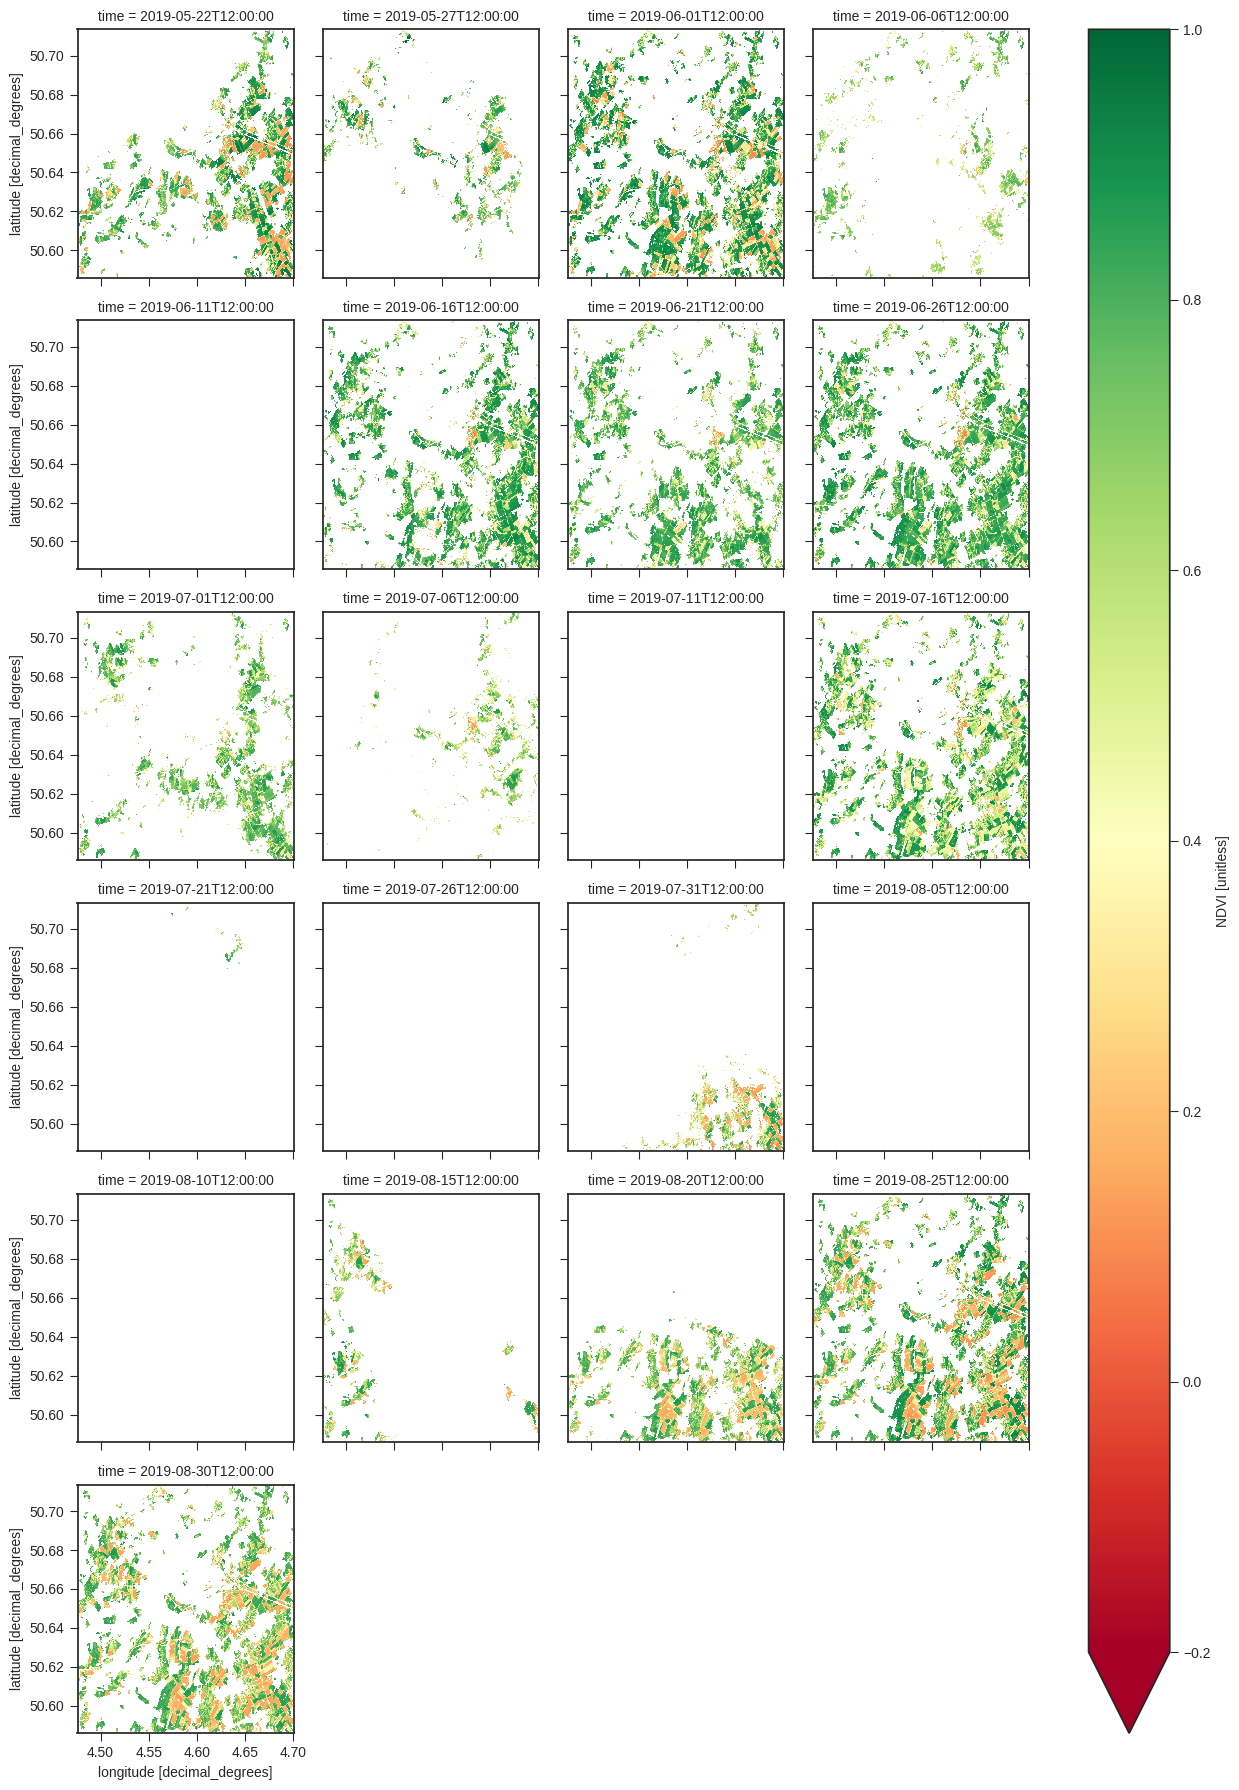

In [35]:
cube_masked.NDVI.plot.imshow(col='time', col_wrap=4, vmin=-0.2, vmax=1,cmap='RdYlGn')
plt.show()

# SAVI

SAVI - Soil Adjusted Vegetation Index - use a transformation technique that minimizes soil brightness influences from spectral vegetation indices involving red and near-infrared (NIR) wavelengths.

SAVI = (1+L) * (NIR - Red) / (NIR + Red + L)

#### Preparing values for new SAVI layer
Now we will prepare values for the new SAVI layer, based on combination of the bands already contained in our cube.

For Sentinel-2 the formula is:

Soil-Adjusted Vegetation Index (SAVI) = ((B08 - B04)* (1.0 + L)) / (B08 + B04 + L) ; L = 0.428

where: L is a soil brightness correction factor ranging from 0 to 1

L = 1 low vegetation cover, L = 0 high vegetation cover, L = 0.5 intermediate vegetation cover.


In [ ]:
L=0.428
savi=(cube.B08-cube.B04)*(1+L)/(cube.B04+cube.B08+L)

savi.attrs['long_name']='SAVI'
savi.attrs['units']='unitless'

#### Adding a new SAVI layer to cube
Now the values are calculated and the properties specified, we can easilly add the new SAVI layer into our cube.

In [ ]:
cube['SAVI']=savi

### Plot SAVI image for specific date

# NDMI

NDMI - Normalized Difference Moisture Index

NDMI = (NIR−SWIR) / (NIR+SWIR)

For Sentinel-2 the formula is:

(B08 - B11)/(B08 + B11)

where:

NIR (band 8) = 842 nm, SWIR (band 11) = 1610 nm